<a href="https://colab.research.google.com/github/Kleyman-Green/CountryProject/blob/master/assignment_1/assignment_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
3430,3699_04,Europa,False,C/123/P,TRAPPIST-1e,57.0,False,0.0,3859.0,13.0,195.0,3874.0,Azhah Tronsive,False
2594,2781_01,Earth,True,G/447/P,TRAPPIST-1e,38.0,False,0.0,0.0,0.0,0.0,0.0,Marice Williotters,False
5376,5740_02,Europa,False,A/52/P,55 Cancri e,32.0,False,70.0,764.0,724.0,547.0,1297.0,Unukath Alaxed,False
8292,8856_01,Earth,True,G/1434/P,PSO J318.5-22,28.0,False,0.0,0.0,0.0,0.0,0.0,Teremy Mckinsond,True
7617,8136_02,Europa,False,C/268/P,TRAPPIST-1e,60.0,False,0.0,5998.0,0.0,4794.0,8.0,Achium Inderad,False
3437,3706_01,Mars,False,F/770/P,TRAPPIST-1e,16.0,False,424.0,0.0,246.0,370.0,0.0,Nilly Kidie,False
7554,8076_01,Europa,False,C/263/P,55 Cancri e,43.0,False,1.0,2060.0,NaN,1.0,2764.0,Menkibi Emetillove,False
7963,8508_01,Mars,True,F/1747/P,TRAPPIST-1e,48.0,False,0.0,0.0,0.0,0.0,0.0,Proos Bake,True
7011,7456_01,Earth,True,G/1210/S,TRAPPIST-1e,21.0,False,0.0,0.0,0.0,0.0,0.0,Yvetta Whitez,True
980,1041_01,Europa,True,NaN,TRAPPIST-1e,46.0,False,0.0,0.0,0.0,0.0,0.0,Algrafi Heedry,True


LogisticRegressionCV metrics:
balanced_accuracy = 0.7615
precision = 0.7656
recall = 0.7574
f1_score = 0.7615
roc_auc = 0.7615
log_loss = 8.5963
          
LinearSVC metrics:
balanced_accuracy = 0.7530
precision = 0.7483
recall = 0.7666
f1_score = 0.7573
roc_auc = 0.7530
log_loss = 8.9003
          


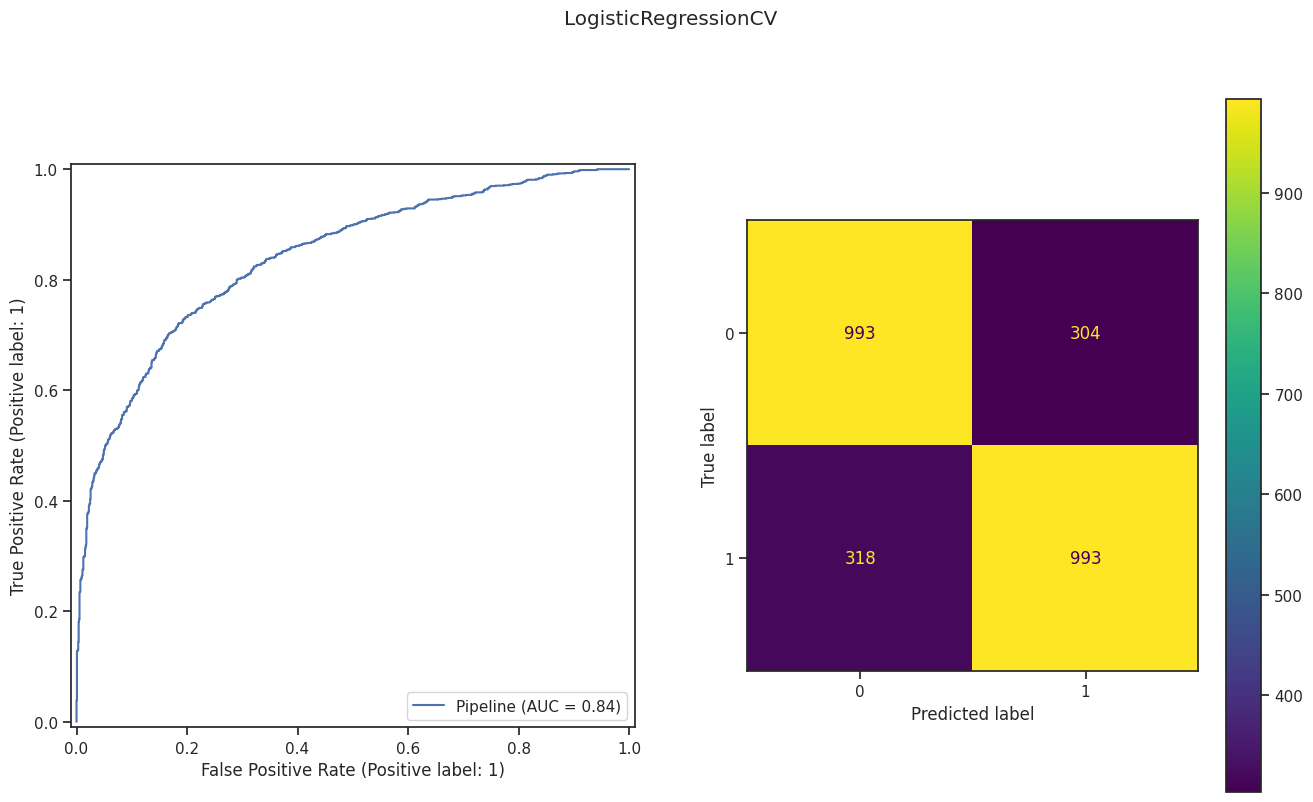

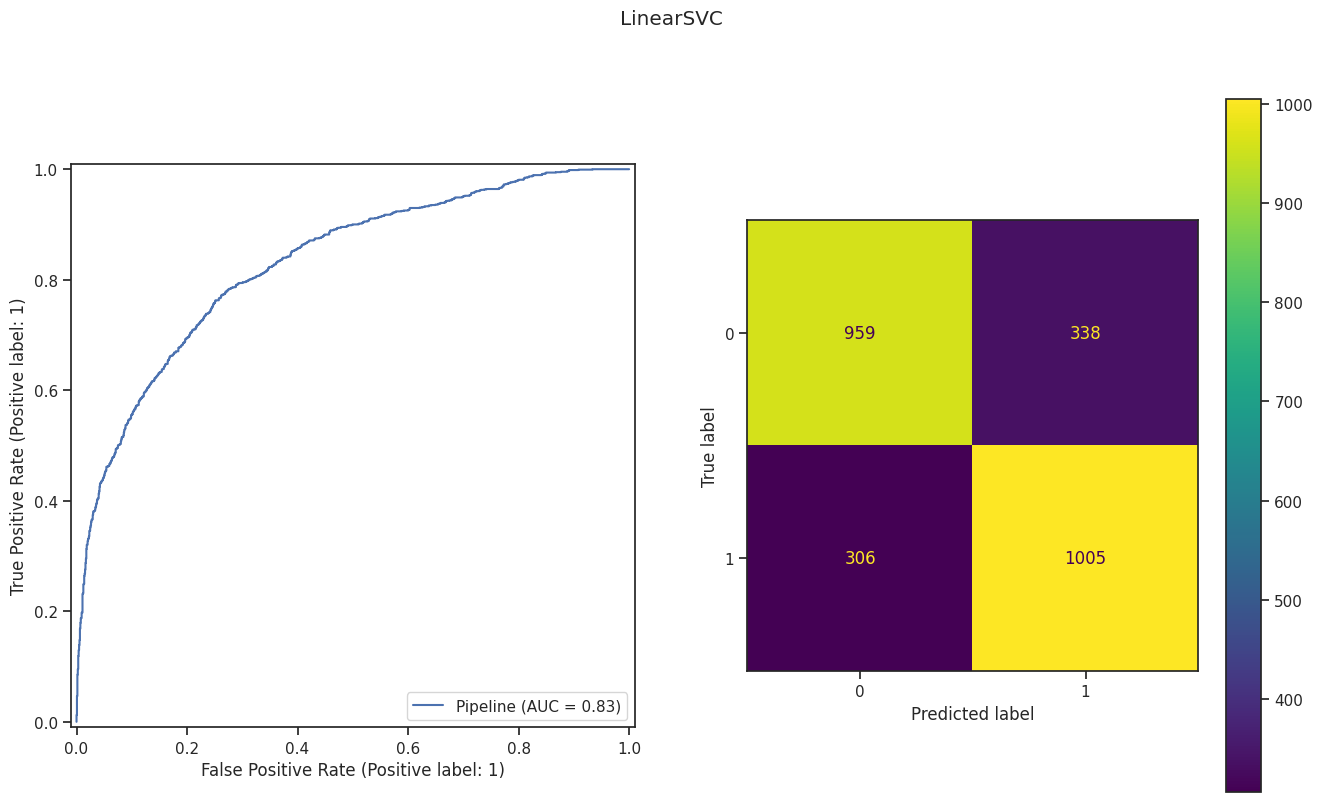

<Axes: xlabel='FoodCourt', ylabel='RoomService'>

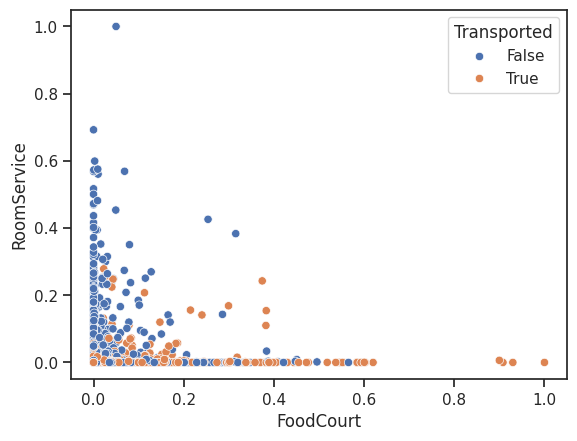

 Правки
- нет подбора гиперпараметров

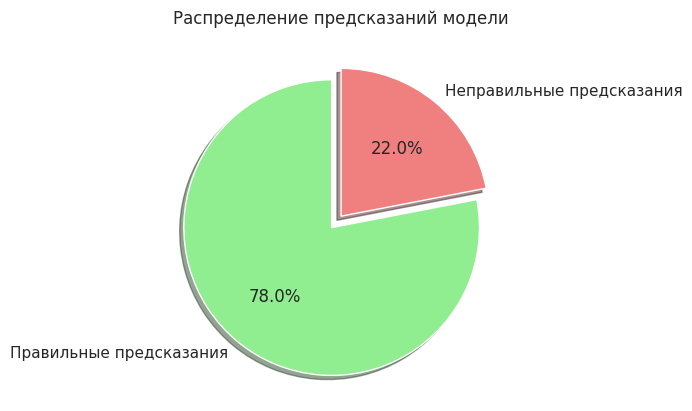

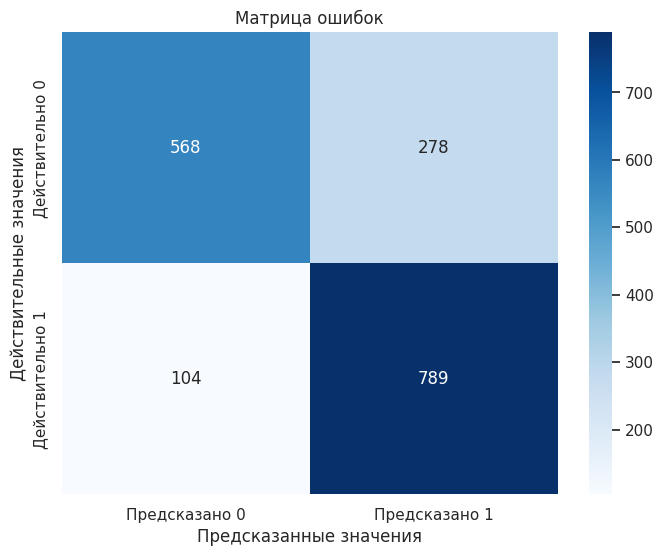

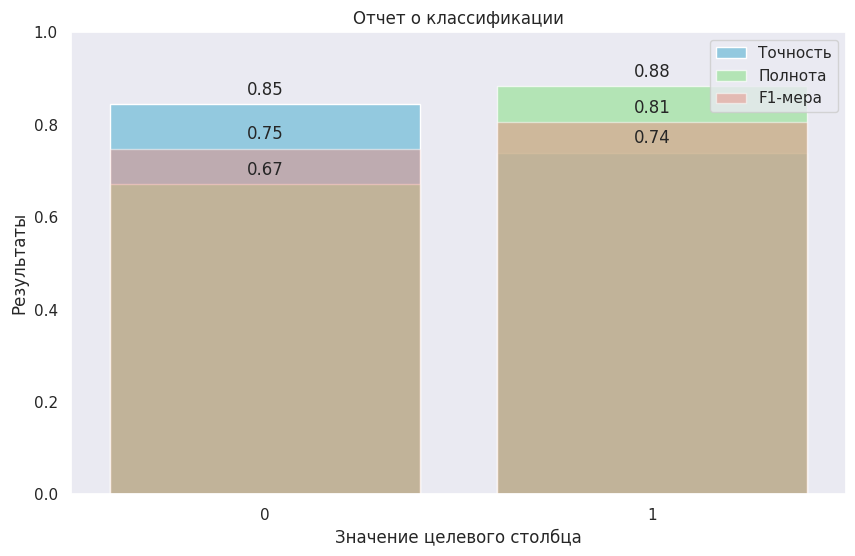

# Правки те же: нет подбора гиперпараметров

In [2]:
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import os

%matplotlib inline
warnings.simplefilter('ignore')
os.environ["PYTHONWARNINGS"] = "ignore" # Also affect subprocesses
sns.set(style='darkgrid')

URL = 'https://gist.githubusercontent.com/LazySlav/a1ed424e46144b637fa504f05a70b331/raw/edfd157471ddd4a510c8e76c70c675930d26788e/assignment_1.csv'
data = pd.read_csv(URL)
data.sample(10)

from sklearn.compose import make_column_transformer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler

LABEL = "Transported"
SEED = 42

# these features likely aren't correlated with label
if "Name" in data.columns and "PassengerId" in data.columns:
    print("Columns Name and PassengerID dropped.")
    data = data.drop(columns=["Name", "PassengerId"])

# https://stackoverflow.com/a/39358924
# https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.Series.str.split.html
# Divide Cabin column into three features, since they can have different influence
# expand=True converts data.str type Series/Index -> DataFrame/MultiIndex
if "Cabin" in data.columns:
    data[["Deck", "Num", "Side"]] = data["Cabin"].str.split("/", n=2, expand=True)
    data = data.drop(columns="Cabin")


# select all boolean, categorical and numeric features
boolean_features = ["CryoSleep", "VIP"]
categorical_features = (
    data.select_dtypes("object")
    .columns.difference(boolean_features)
    .tolist()
)
numerical_features = data.select_dtypes("number").columns.tolist()

boolean_transformer = make_pipeline(
    SimpleImputer(strategy='constant', fill_value=False),
    OrdinalEncoder(dtype=int),
)

categorical_transformer = make_pipeline(
    SimpleImputer(strategy="constant", fill_value='NotGiven'),
    OneHotEncoder(handle_unknown="ignore"),
)

numerical_transformer = make_pipeline(
    SimpleImputer(strategy="mean"),
    StandardScaler(),
)

preprocessor = make_column_transformer(
    (boolean_transformer, boolean_features),
    (categorical_transformer, categorical_features),
    (numerical_transformer, numerical_features),
)

y = data[LABEL]
y = y.fillna(False).astype(int)

X = data.drop(columns=[LABEL])

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=SEED
)


Columns Name and PassengerID dropped.


In [3]:
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import (
    balanced_accuracy_score,
    f1_score,
    log_loss,
    precision_score,
    recall_score,
    roc_auc_score,
)

models = (
    LogisticRegression(),
    LinearSVC(),
)

best_models = {}

predictions = {}

for model in models:
    model_name = model.__class__.__name__.lower()
    param_grid = {
        f"{model_name}__C": np.logspace(-4,4,5),
        f"{model_name}__max_iter": np.linspace(1000,10000,5).astype(dtype=int),
        f"{model_name}__tol": np.logspace(-8,-1,5),
    }
    pipeline = make_pipeline(preprocessor, model)

#ГИПЕРПАРАМЕТРЫ

    grid_search = GridSearchCV(
            estimator=pipeline,
            param_grid=param_grid,
            cv=5,
            scoring='neg_mean_squared_error',
            n_jobs=-1
    )
    grid_search.fit(X_train, y_train)

    best_model = grid_search.best_estimator_

    best_model.fit(X_train, y_train)
    y_pred = best_model.predict(X_test)

    # for future use in JPNB cells
    best_models[model_name] = best_model
    predictions[model_name]=y_pred

    print(f"{model_name} best_params:",
          f"{best_model.named_steps[model_name].get_params()}"
          f"{model_name} metrics:",
          f"{balanced_accuracy_score(y_test, y_pred) = !s}",
          f"{precision_score(y_test, y_pred) = !s}",
          f"{recall_score(y_test, y_pred) = !s}",
          f"{f1_score(y_test, y_pred) = !s}",
          f"{roc_auc_score(y_test, y_pred) = !s}",
          f"{log_loss(y_test, y_pred) = !s}",
          sep="\n", end ="\n"*2+"-"*10+"\n"*2)


logisticregression best_params:
{'C': 1.0, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': None, 'max_iter': 1000, 'multi_class': 'deprecated', 'n_jobs': None, 'penalty': 'l2', 'random_state': None, 'solver': 'lbfgs', 'tol': 0.0017782794100389228, 'verbose': 0, 'warm_start': False}logisticregression metrics:
balanced_accuracy_score(y_test, y_pred) = 0.7830346708105148
precision_score(y_test, y_pred) = 0.772005772005772
recall_score(y_test, y_pred) = 0.8112206216830933
f1_score(y_test, y_pred) = 0.7911275415896488
roc_auc_score(y_test, y_pred) = 0.7830346708105148
log_loss(y_test, y_pred) = 7.808536873025763

----------

linearsvc best_params:
{'C': 0.01, 'class_weight': None, 'dual': 'auto', 'fit_intercept': True, 'intercept_scaling': 1, 'loss': 'squared_hinge', 'max_iter': 1000, 'multi_class': 'ovr', 'penalty': 'l2', 'random_state': None, 'tol': 1e-08, 'verbose': 0}linearsvc metrics:
balanced_accuracy_score(y_test, y_pred) = 0.7807690430

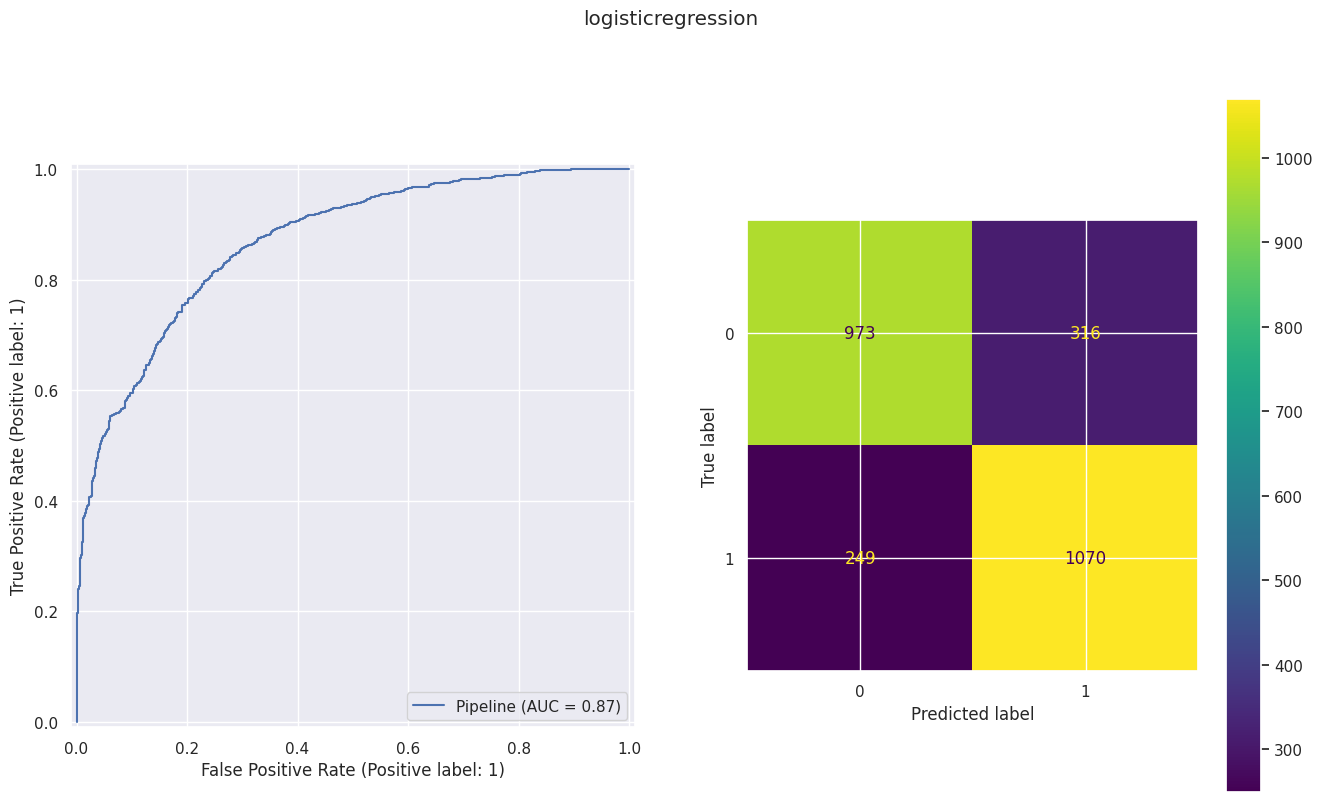

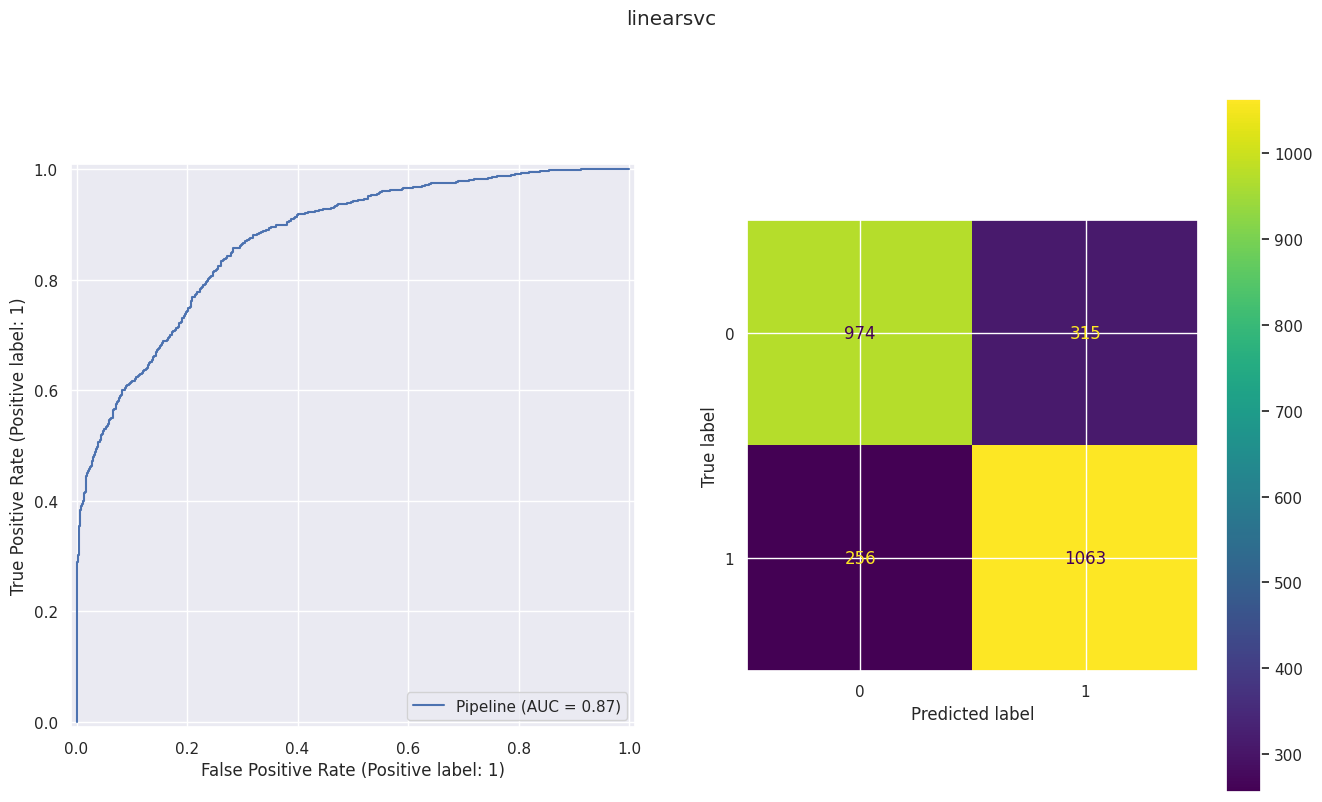

In [4]:
from sklearn.metrics import ConfusionMatrixDisplay, RocCurveDisplay

for model_name, model in best_models.items():
    fig, axes = plt.subplots(1, 2, figsize=(16, 9))
    fig.suptitle(model_name)
    RocCurveDisplay.from_estimator(model, X_test, y_test, ax=axes[0])
    # Need to investigate why this is crooked but coincides with roc_auc_score
    # RocCurveDisplay.from_predictions(y_test, predictions[model_name])
    ConfusionMatrixDisplay.from_estimator(model, X_test, y_test, ax=axes[1])
    plt.show()
